In [57]:
import os
import pickle
import cv2
import numpy as np
import pandas as pd
import csv
import math
import json

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.stats import bernoulli

# Import keras deep learning libraries
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.activations import relu
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2

import tensorflow as tf

tf.python.control_flow_ops = tf
print('Modules loaded.')

Modules loaded.


In [59]:
#DATA_DIR = './data/'
DRIVING_LOG_FILE = './data/driving_log.csv'
IMG_PATH = './data/'
STEERING_COEFFICIENT = 0.229
CENTER_CAM_FILE = 0
LEFT_CAM_FILE = 1
RIGHT_CAM_FILE = 2

### Dataset Statistics

In [27]:
def get_stastical_data(file):
    driving_log = pd.read_csv(file)
    steering = pd.to_numeric(driving_log['steering'], errors='coerce')
    left_steering = steering[steering <0]
    right_steering = steering[steering >0]
    center_steering = steering[steering ==0]
    num_samples = len(driving_log)
    return {
        'num_samples' :  num_samples,
        'left_steering' : {
            'num_samples': len(left_steering),
            'min' : np.min(left_steering),
            'mean': np.mean(left_steering),
            'median': np.median(left_steering)          
        },
        'right_steering' : {
            'num_samples': len(right_steering),
            'max' : np.min(right_steering),
            'mean': np.mean(right_steering),
            'median': np.median(right_steering)          
        },
        'center_steering' : {
            'num_samples': num_samples - len(left_steering) - len(right_steering),
            'max' : np.min(center_steering),
            'mean': np.mean(center_steering),
            'median': np.median(center_steering)
        }
        
    }


import pprint 
pprint.pprint(get_stastical_data(DRIVING_LOG_FILE))

{'center_steering': {'max': 0.0,
                     'mean': 0.0,
                     'median': 0.0,
                     'num_samples': 4361},
 'left_steering': {'mean': -0.1462814969391549,
                   'median': -0.11672329999999999,
                   'min': -0.94269539999999996,
                   'num_samples': 1775},
 'num_samples': 8036,
 'right_steering': {'max': 0.0043487109999999999,
                    'mean': 0.15387016672210527,
                    'median': 0.13830820000000002,
                    'num_samples': 1900}}


### Dataset Augmentation

In [60]:
def augmentation_shadow(image):
    img_shape = image.shape
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = img_shape[0]
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

def augmentation_trans(image, steer, trans_range):
    img_shape = image.shape
    #print(type())
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = steer + tr_x / trans_range * 2 * .2
    tr_y = 40 * np.random.uniform() - 40 / 2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image_tr = cv2.warpAffine(image, Trans_M, (img_shape[1], img_shape[0]))

    return image_tr, steer_ang

def augmentation_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = np.random.uniform(0.25, 1.25)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def augmentation_crop(image, steering):
    img_shape = image.shape
    #img[0: math.floor(img_shape[0] / 5), :, :] = int(steering*128+127)
    #img[img_shape[0] - 25: img_shape[0], :, :] = int(steering*128+127)

    image = image[math.floor(img_shape[0] / 5):img_shape[0] - 25, :, :]
    return image


def augmentation_flip(image, steering):
    i = np.random.randint(2)
    if i == 0:
        image = cv2.flip(image, 1)
        steering = - steering
    return image, steering

def augmentation_gamma(image):
    """
    Random gamma correction is used as an alternative method changing the brightness of
    training images.
    http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
    :param image:
        Source image
    :return:
        New image generated by applying gamma correction to the source image
    """
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


def augmentation_shear(image, steering, shear_range=200):
    """
    Source: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk
    :param image:
        Source image on which the shear operation will be applied
    :param steering_angle:
        The steering angle of the image
    :param shear_range:
        Random shear between [-shear_range, shear_range + 1] will be applied
    :return:
        The image generated by applying random shear on the source image
    """
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering += dsteering

    return image, steering


def generate_new_image(image, steering_angle, do_shear_prob=0.9):

    head = bernoulli.rvs(do_shear_prob)
    if head == 1:
        image, steering_angle = augmentation_shear(image, steering_angle)
            
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = augmentation_brightness(image)
    #img = augmentation_gamma(img)
    image, steering_angle = augmentation_trans(image, steering_angle, 100)
    image = augmentation_crop(image, steering_angle)
    image = augmentation_shadow(image)
    image = np.array(image)
    image, steering_angle = augmentation_flip(image, steering_angle)
    
    return image, steering_angle


def get_image(DRIVING_LOG_FILE, batch_size=64):
    """
    The simulator records three images (namely: left, center, and right) at a given time
    However, when we are picking images for training we randomly (with equal probability)
    one of these three images and its steering angle.
    :param batch_size:
        Size of the image batch
    :return:
        An list of selected (image files names, respective steering angles)
    """
    data = pd.read_csv(DRIVING_LOG_FILE)
    num_of_img = len(data)
    rnd_indices = np.random.randint(0, num_of_img, size = batch_size)

    image_and_steering = []
    for index in rnd_indices:
        rnd_image = np.random.randint(0, 3)
        if rnd_image == CENTER_CAM_FILE:
            img = data.iloc[index]['left'].strip()
            steering = data.iloc[index]['steering'] + STEERING_COEFFICIENT
            image_and_steering.append((img, steering))

        elif rnd_image == LEFT_CAM_FILE:
            img = data.iloc[index]['center'].strip()
            steering = data.iloc[index]['steering']
            image_and_steering.append((img, steering))
        elif rnd_image == RIGHT_CAM_FILE:
            img = data.iloc[index]['right'].strip()
            steering = data.iloc[index]['steering'] - STEERING_COEFFICIENT
            image_and_steering.append((img, steering))

    return image_and_steering


def myGenerator(batch_size=64):
    """
    This generator yields the next training batch
    :param batch_size:
        Number of training images in a single batch
    :return:
        A tuple of features and steering angles as two numpy arrays
    """
    while True:
        X_batch = []
        y_batch = []
        images = get_image(DRIVING_LOG_FILE, batch_size)
        for img_file, steering in images:
            image = plt.imread(IMG_PATH + img_file)
            new_image, new_steering = generate_new_image(image, steering)
            X_batch.append(new_image)
            y_batch.append(new_steering)

        assert len(X_batch) == batch_size, 'len(X_batch) == batch_size should be True'

        yield np.array(X_batch), np.array(y_batch)


### Dataset example

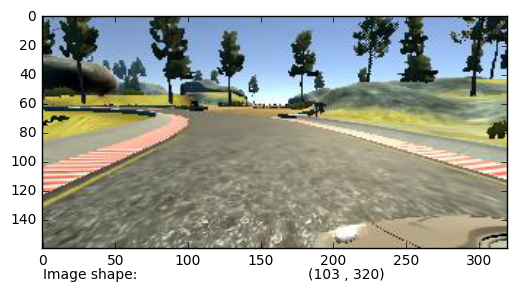

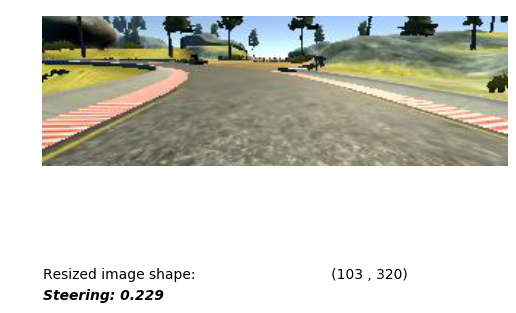

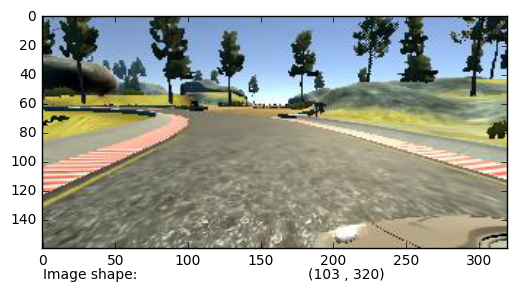

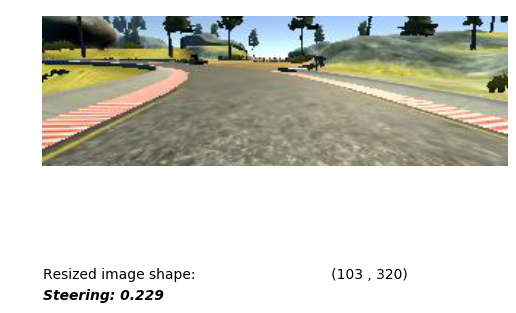

In [61]:
## 
img_example = get_image(DRIVING_LOG_FILE, batch_size=64)

rdn_indx = np.random.randint(len(img_example), size=2)

for indx in rdn_indx:
    img_file = img_example[0][0]
    image = plt.imread(IMG_PATH + img_file)
    steering = img_example[0][1]

    resized_image = augmentation_crop(image, 0)
      
    
    plt.figure()
    plt.imshow(image)

    txt1= '{0:50} ({1:d} , {2:d})'.format('Image shape:', resized_image.shape[0], resized_image.shape[1])
    plt.text(0,image.shape[0]+20, txt1 ) 

    plt.figure()
    plt.imshow(resized_image)

    txt2 = '{0:50} ({1:d} , {2:d})'.format('Resized image shape:', resized_image.shape[0], resized_image.shape[1])
    plt.text(0,image.shape[0]+20, txt2 )
    plt.axis('off')
    plt.text(0,image.shape[0]+35,'Steering: %.3f' % steering , style='italic',fontweight='bold')

###  Model Architecture

In [56]:
# Build a model
def nvidia_model():
    learning_rate = 0.0001
    # number of convolutional filters to use
    n_filters1 = 24
    n_filters2 = 36
    n_filters3 = 48
    n_filters4 = 64
    n_filters5 = 64
    
    # convolution kernel size
    kernel_size1 = (5, 5)
    kernel_size2 = (3, 3)

    model = Sequential()
    model.add(Lambda(lambda x: x / 255. - 0.5, input_shape = crop_shape, output_shape = crop_shape))
    model.add(Convolution2D(3, 5, 5, border_mode="same", subsample=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(n_filters1, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), border_mode='same', strides = (1, 1) ))
    model.add(Dropout(0.5))


    model.add(Convolution2D(n_filters2, 5, 5, border_mode='same', subsample=(2, 2)))#subsample: tuple of length 2 or strides
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), border_mode='same', strides = (1, 1) ))
    model.add(Dropout(0.5))


    model.add(Convolution2D(n_filters3, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), border_mode='same', strides = (1, 1) ))
    model.add(Dropout(0.5))


    model.add(Convolution2D(n_filters4, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), border_mode='same', strides = (1, 1) ))
    model.add(Dropout(0.5))


    model.add(Convolution2D(n_filters5, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), border_mode='same', strides = (1, 1) ))
    model.add(Dropout(0.5))


    # Flatten the matrix
    model.add(Flatten())

    # 5 Fully-connected layers
    model.add(Dense(1164))
    model.add(Activation('relu'))

    model.add(Dense(100))
    model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('relu'))

    model.add(Dense(1))


    # Compile and train the model
    #model.compile(optimizer = Adam(lr=learning_rate), loss='mean_squared_error', metrics=['accuracy'])
    model.compile(optimizer = Adam(lr=learning_rate), loss='mean_squared_error')
    
    #history = model.fit(X_train, y_train, batch_size=128, nb_epoch=10, 
    #                    validation_split=0.2, validation_data=(X_val,y_val))
    return model

# THE summary of the model
model = nvidia_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_8 (Lambda)                (None, 103, 320, 3)   0           lambda_input_8[0][0]             
____________________________________________________________________________________________________
convolution2d_43 (Convolution2D) (None, 52, 160, 3)    228         lambda_8[0][0]                   
____________________________________________________________________________________________________
activation_71 (Activation)       (None, 52, 160, 3)    0           convolution2d_43[0][0]           
____________________________________________________________________________________________________
convolution2d_44 (Convolution2D) (None, 26, 80, 24)    1824        activation_71[0][0]              
___________________________________________________________________________________________

In [53]:
def train_model(model, training_generator, number_of_epochs, number_of_samples_per_epoch, validation_generator, number_of_validation_samples):
        return model.fit_generator(training_generator, 
                               nb_epoch = number_of_epochs, 
                               samples_per_epoch = number_of_samples_per_epoch,    
                               verbose=1,                                   
                               validation_data= validation_generator, 
                               nb_val_samples= number_of_validation_samples)
    
def test_model(model, X_test, y_test, batch_size=4):
    return model.evaluate(X_test, y_test, batch_size = batch_size, verbose=1)


def predict(model, X_test, batch_size=4):
    return model.predict(X_test, batch_size = batch_size)
  

def save_model(model, model_name='model.json', model_weights='model.h5'):
    
    if model_name in os.listdir():
        print("The model file already exists")
        print("Want to overwite? y or n")
        user_input = input()

        if user_input == "y":
        # Save model as json file
            model_json = model.to_json()

            with open(model_name, 'w') as outfile:
                #outfile.write(model_json)
                json.dump(model_json, outfile)
                # save weights
                model.save_weights(model_weights)
                print('saved model to disk')
        else:
            print("the model is not saved")
    else:
        # Save model as json file
        model_json = model.to_json()

        with open(model_name, 'w') as outfile:
            #outfile.write(model_json)
            json.dump(model_json, outfile)
            # save weights
            model.save_weights(model_weights)
            print('saved model to disk')
            
            

def load_model(model_name='model.json', model_weights='model.h5'):  
    with open(model_name, 'r') as outfile:
        model = model_from_json(json.load(outfile))
        model.load_weights(model_weights)
    return model

### Training dataset

In [62]:
# 1. define hyperparameters
batch_size = 512

number_of_epochs = 8
number_of_samples_per_epoch = 20032
number_of_validation_samples = 6400
#number_of_samples_per_epoch = 200
#number_of_validation_samples = 400

img_example = get_image(DRIVING_LOG_FILE)
img_file = img_example[0][0]
image = plt.imread(IMG_PATH + img_file)
resized_image = augmentation_crop(image, 0)

img_shape = image.shape
print(img_shape)
crop_shape = resized_image.shape
print(crop_shape)


def main(log_file_path, save_to_disk=True, load_from_disk=False):
    if load_from_disk:
        model = load_model()
    else:
        # 2. create model model
        model = nvidia_model()

        #3. create two generators for training and validation
        training_generator = myGenerator()
        validation_generator = myGenerator()
        #next(train_gen)[0].shape
        
        # 4. train and save
        train_model(model, training_generator, number_of_epochs, number_of_samples_per_epoch, 
                    validation_generator, number_of_validation_samples)
    
        # 5. check
        val = []
        
        check_image_file = ['IMG/center_2016_12_01_13_31_15_208.jpg', 
                            'IMG/center_2016_12_01_13_45_13_420.jpg', 
                            'IMG/center_2016_12_01_13_45_07_636.jpg']
        check_steering = [0, -0.4110484, 0.4540697]

        for img_file in check_image_file:
            image = plt.imread(IMG_PATH + img_file)
            val.append(augmentation_crop(image, 0))

        #prediction = model.predict(np.array(val))
        prediction = predict(model, np.array(val))
        print('Predicted steering angles: ',prediction)
        print('True steering angles: ',check_steering)


    if save_to_disk:
        save_model(model)

(160, 320, 3)
(103, 320, 3)


In [55]:
if __name__ == "__main__":
    main(DRIVING_LOG_FILE)

Epoch 1/8
20032/20032 [==============================] - 396s - loss: 0.1661 - val_loss: 0.2820

Reference 
- [Udacity self-driving-car project](https://github.com/udacity/self-driving-car)
- [Nvidia Paper: End to End Learning for Self-Driving Cars](https://arxiv.org/pdf/1604.07316v1.pdf)
- [Introduction to Python Generators](http://intermediatepythonista.com/python-generators)